## Apprentissage sur données textuelles
On termine cette étude par une analyse de données textuelles. En l'occurrence, on cherche à identifier des spams dans une base de SMS. 
### Chargement des données

In [1]:
import numpy as np
np.set_printoptions(threshold=1000000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./SMSSpamCollection.data", sep="\t")
data_array = data.values
X = data_array[:,1]
Y = data_array[:,0]

Y = np.where(Y=='spam', 1, Y)
Y = np.where(Y=='ham', 0, Y)
Y = Y.astype(np.int)

print("Taille de l'échantillon : ", X.shape)

n_zeros = np.histogram(Y)[0][0]
n_ones = np.histogram(Y)[0][-1]
print("Nombre d'entrée 0 : ", n_zeros, " (", round(n_zeros*100/len(Y), 2),"%)")
print("Nombre d'entrée 1 : ", n_ones, " (", round(n_ones*100/len(Y), 2),"%)")

Taille de l'échantillon :  (5571,)
Nombre d'entrée 0 :  4824  ( 86.59 %)
Nombre d'entrée 1 :  747  ( 13.41 %)


In [3]:
np.unique(Y)

array([0, 1])

La base contient 5571 SMS dont 13% sont des spams.
### Count Vectorizer
Une première étape consiste à transformer les données textuelles en données numériques afin de pouvoir les exploiter par un algorithme de classification. Pour cela, on propose d'encoder chaque mot présent dans la base grâce à une variable binaire   (*True* si le mot est présent dans la ligne et *False* sinon). Cela produit une matrice dite *sparse* des données. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=300,stop_words="english")
X_vec = vectorizer.fit_transform(X)
print(X_vec.shape)

(5571, 300)


### Comparaison de plusieurs algorithmes
Pour comparer les différents algorithmes, nous utilisons plusieurs métriques, : l'accuracy, l'aire sur la courbe AUC qui doit être proche de 1, le temps de calcul nécessaire et la précision. 

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate , KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer

scoring = {'AUC': 'roc_auc','Accuracy': make_scorer(accuracy_score)}



def run_classifiers(clfs, X, Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf2 = KFold(n_splits=5, shuffle=True, random_state=0)
    for i in clfs:
        clf = clfs[i]
        cv = cross_validate(clf, X, Y, cv=kf, scoring=scoring)
        cv2 = cross_validate(clf, X, Y, cv=kf2, scoring={"Precision" : make_scorer(precision_score)})
        cv_time = cv['fit_time']
        cv_acc = cv['test_Accuracy']
        cv_auc = cv["test_AUC"]
        cv_prec = cv2["test_Precision"]
        print(i, "(", round(np.mean(cv_time)*1000, 1), "ms)")
        print("\t Accuracy :", round(np.mean(cv_acc),2)*100,"+/-", round(np.std(cv_acc)*100,1),"%")
        print("\t AUROC :", round(np.mean(cv_auc),2),"+/-", round(np.std(cv_auc),2))
        print("\t Précision :", round(np.mean(cv_prec),2)*100,"+/-", round(np.std(cv_prec)*100,1),"%")
        
        
clfs = {"Tree" : DecisionTreeClassifier(),
"MLP" : MLPClassifier([20, 10]),
"KNN" : KNeighborsClassifier(n_neighbors=19, p=1),
"Bagging" : BaggingClassifier(n_estimators=50),
"Adaboost" : AdaBoostClassifier(n_estimators=50),
"Randomforest" : RandomForestClassifier(n_estimators=50)}

run_classifiers(clfs, X_vec.toarray(), Y)

Tree ( 435.5 ms)
	 Accuracy : 96.0 +/- 0.9 %
	 AUROC : 0.93 +/- 0.02
	 Précision : 88.0 +/- 1.2 %
MLP ( 3966.5 ms)
	 Accuracy : 98.0 +/- 0.6 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 93.0 +/- 1.6 %
KNN ( 3.4 ms)
	 Accuracy : 90.0 +/- 1.3 %
	 AUROC : 0.94 +/- 0.01
	 Précision : 100.0 +/- 0.0 %
Bagging ( 10383.0 ms)
	 Accuracy : 97.0 +/- 0.8 %
	 AUROC : 0.98 +/- 0.01
	 Précision : 89.0 +/- 1.2 %
Adaboost ( 840.9 ms)
	 Accuracy : 97.0 +/- 0.9 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 94.0 +/- 1.6 %
Randomforest ( 975.0 ms)
	 Accuracy : 98.0 +/- 0.8 %
	 AUROC : 0.98 +/- 0.01
	 Précision : 93.0 +/- 1.8 %


Pour l'instant on utilise la totalité des données, soit une matrice de données *sparse* de taille $5571\times 8711$. Les temps de calculs sont très longs, mais les performances sont excellentes, notamment pour le MLP* qui parvient à atteindre une classification quasi-parfaite.

   <table border="0" cellpadding="0" cellspacing="0" id="sheet0" class="sheet0 gridlines">
        <col class="col0">
        <col class="col1">
        <col class="col2">
        <col class="col3">
        <col class="col4">
        <tbody>
          <tr class="row0">
            <td class="column0 style1 null"></td>
            <td class="column1 style1 s">Accuracy</td>
            <td class="column2 style1 s">Précision</td>
            <td class="column3 style1 s">Auroc</td>
            <td class="column4 style6 s">time</td>
          </tr>
          <tr class="row1">
            <td class="column0 style1 s">CART</td>
            <td class="column1 style2 s">96.0%</td>
            <td class="column2 style3 s">88.0%</td>
            <td class="column3 style1 s">0.93</td>
            <td class="column4 style5 s">129.7ms</td>
          </tr>
          <tr class="row2">
            <td class="column0 style1 s">MLP</td>
            <td class="column1 style4 s"><strong/>98.0%</strong></td>
            <td class="column2 style3 s"><strong>93.0%</strong></td>
            <td class="column3 style5 s">0.97</td>
            <td class="column4 style5 s">6818ms</td>
          </tr>
          <tr class="row3">
            <td class="column0 style5 s">KNN</td>
            <td class="column1 style2 s">90.0%</td>
            <td class="column2 style3 s"><strong>100.0%<strong></td>
            <td class="column3 style5 s">0.93</td>
            <td class="column4 style1 s"><strong>0.9ms</strong></td>
          </tr>
          <tr class="row4">
            <td class="column0 style6 s">Bagging</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">89.0%</td>
            <td class="column3 style3 s">0.97</td>
            <td class="column4 style5 s">4439ms</td>
          </tr>
          <tr class="row5">
            <td class="column0 style6 s">Adaboost</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">94.0%</td>
            <td class="column3 style6 s">0.97</td>
            <td class="column4 style7 s">1687ms</td>
          </tr>
          <tr class="row6">
            <td class="column0 style6 s">RandomForest</td>
            <td class="column1 style2 s">98.0%</td>
            <td class="column2 style3 s"><strong>93.0%</strong></td>
            <td class="column3 style7 s"><strong>0.98</strong></td>
            <td class="column4 style7 s">1401ms</td>
          </tr>
          <tr class="row7">
            <td class="column0 style8 null"></td>
            <td class="column1 style9 null"></td>
            <td class="column2 style10 null"></td>
            <td class="column3 style8 null"></td>
            <td class="column4 style8 null"></td>
          </tr>
        </tbody>
    </table>

### TF-IDF term weighting
Cette méthode est très gourmande en emplacement mémoire et en temps de calcul (notamment sur des bases de données plus conséquentes). Une solution serait d'utiliser TF-IDF : utiliser TF-IDF plutôt que le nombre d'occurrences de chaque mot dans un document permet de diminuer l'impact des mots à la fois très fréquents dans le texte et portant moins d'informations.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
X_Tfidf = transformer.fit_transform(X_vec)
run_classifiers(clfs, X_vec.toarray(), Y)

Tree ( 439.3 ms)
	 Accuracy : 96.0 +/- 0.9 %
	 AUROC : 0.93 +/- 0.02
	 Précision : 87.0 +/- 0.7 %
MLP ( 3587.5 ms)
	 Accuracy : 98.0 +/- 0.6 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 92.0 +/- 1.7 %
KNN ( 3.4 ms)
	 Accuracy : 90.0 +/- 1.3 %
	 AUROC : 0.94 +/- 0.01
	 Précision : 100.0 +/- 0.0 %
Bagging ( 10024.7 ms)
	 Accuracy : 97.0 +/- 0.8 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 89.0 +/- 0.6 %
Adaboost ( 869.0 ms)
	 Accuracy : 97.0 +/- 0.9 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 94.0 +/- 1.6 %
Randomforest ( 916.1 ms)
	 Accuracy : 98.0 +/- 1.0 %
	 AUROC : 0.98 +/- 0.01
	 Précision : 94.0 +/- 2.6 %


Nous ne tenons compte que des 1000 termes les plus fréquents et nous retirons les mots anglais qui ne portent pas toujours d'informations.
<table>
<tr><td><th>Count Vectorizer + TF-IDF	 </th></td><th>Count Vectorizer + TF IDF transformer</th></tr>
<tr><td width="250px">
<td>
  <table border="0" cellpadding="0" cellspacing="0" id="sheet0" class="sheet0 gridlines">
        <col class="col0">
        <col class="col1">
        <col class="col2">
        <col class="col3">
        <col class="col4">
        <tbody>
          <tr class="row0">
            <td class="column0 style1 null"></td>
            <td class="column1 style1 s">Accuracy</td>
            <td class="column2 style1 s">Précision</td>
            <td class="column3 style1 s">Auroc</td>
            <td class="column4 style6 s">time</td>
          </tr>
          <tr class="row1">
            <td class="column0 style1 s">CART</td>
            <td class="column1 style2 s">96.0%</td>
            <td class="column2 style3 s">88.0%</td>
            <td class="column3 style1 s">0.93</td>
            <td class="column4 style5 s">129.7ms</td>
          </tr>
          <tr class="row2">
            <td class="column0 style1 s">MLP</td>
            <td class="column1 style4 s"><strong/>98.0%</strong></td>
            <td class="column2 style3 s"><strong>93.0%</strong></td>
            <td class="column3 style5 s">0.97</td>
            <td class="column4 style5 s">6818ms</td>
          </tr>
          <tr class="row3">
            <td class="column0 style5 s">KNN</td>
            <td class="column1 style2 s">90.0%</td>
            <td class="column2 style3 s"><strong>100.0%<strong></td>
            <td class="column3 style5 s">0.93</td>
            <td class="column4 style1 s"><strong>0.9ms</strong></td>
          </tr>
          <tr class="row4">
            <td class="column0 style6 s">Bagging</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">89.0%</td>
            <td class="column3 style3 s">0.97</td>
            <td class="column4 style5 s">4439ms</td>
          </tr>
          <tr class="row5">
            <td class="column0 style6 s">Adaboost</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">94.0%</td>
            <td class="column3 style6 s">0.97</td>
            <td class="column4 style7 s">1687ms</td>
          </tr>
          <tr class="row6">
            <td class="column0 style6 s">RandomForest</td>
            <td class="column1 style2 s">98.0%</td>
            <td class="column2 style3 s"><strong>93.0%</strong></td>
            <td class="column3 style7 s"><strong>0.98</strong></td>
            <td class="column4 style7 s">1401ms</td>
          </tr>
          <tr class="row7">
            <td class="column0 style8 null"></td>
            <td class="column1 style9 null"></td>
            <td class="column2 style10 null"></td>
            <td class="column3 style8 null"></td>
            <td class="column4 style8 null"></td>
          </tr>
        </tbody>
    </table>

<td>
<table border="0" cellpadding="0" cellspacing="0" id="sheet0" class="sheet0 gridlines">
        <col class="col0">
        <col class="col1">
        <col class="col2">
        <col class="col3">
        <col class="col4">
        <tbody>
          <tr class="row0">
            <td class="column0 style1 null"></td>
            <td class="column1 style1 s">Accuracy</td>
            <td class="column2 style1 s">Précision</td>
            <td class="column3 style1 s">Auroc</td>
            <td class="column4 style6 s">time</td>
          </tr>
          <tr class="row1">
            <td class="column0 style1 s">CART</td>
            <td class="column1 style2 s"><strong>97.0%</strong></td>
            <td class="column2 style3 s">88.0%</td>
            <td class="column3 style1 s">0.93</td>
            <td class="column4 style5 s"><strong>128.5ms</strong></td>
          </tr>
          <tr class="row2">
            <td class="column0 style1 s">MLP</td>
            <td class="column1 style4 s">98.0%</td>
            <td class="column2 style3 s">96.0%</td>
            <td class="column3 style5 s"><strong>0.99</strong></td>
            <td class="column4 style5 s"><strong>2200ms</strong></td>
          </tr>
          <tr class="row3">
            <td class="column0 style5 s">KNN</td>
            <td class="column1 style2 s">88.0%</td>
            <td class="column2 style3 s">100.0%</td>
            <td class="column3 style5 s">0.83</td>
            <td class="column4 style1 s">1.1ms</td>
          </tr>
          <tr class="row4">
            <td class="column0 style6 s">Bagging</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">91.0%</td>
            <td class="column3 style3 s">0.98</td>
            <td class="column4 style5 s"><strong>3815ms</strong></td>
          </tr>
          <tr class="row5">
            <td class="column0 style6 s">Adaboost</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">94.0%</td>
            <td class="column3 style6 s">0.97</td>
            <td class="column4 style7 s"><strong>157ms</strong></td>
          </tr>
          <tr class="row6">
            <td class="column0 style6 s">RandomForest</td>
            <td class="column1 style2 s">98.0%</td>
            <td class="column2 style3 s">98.0%</td>
            <td class="column3 style7 s">0.99</td>
            <td class="column4 style7 s"><strong>293.9ms</strong></td>
          </tr>
          <tr class="row7">
            <td class="column0 style8 null"></td>
            <td class="column1 style9 null"></td>
            <td class="column2 style10 null"></td>
            <td class="column3 style8 null"></td>
            <td class="column4 style8 null"></td>
          </tr>
        </tbody>
    </table>
</td>
</td><td width="500px">


</td></tr> </table>

L'utilisation de TF-IDF permet de réduire le temps de calcul en n'impactant pas trop les performances générales.

### TruncatedSVD
Afin de limiter l'utilisation de l'espace mémoire et du temps de calcul, on fait appel à un algorithme de réduction de dimension sur le même principe que PCA, mais sans centrer les features. (NB : en cas de crash, il faut relancer le programme bloc par bloc, à partir du chargement des données textuelles)

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=30)
svd.fit(X_Tfidf)
X_svd = svd.transform(X_Tfidf)


run_classifiers(clfs, X_svd, Y)

Tree ( 106.3 ms)
	 Accuracy : 96.0 +/- 0.8 %
	 AUROC : 0.92 +/- 0.02
	 Précision : 84.0 +/- 3.1 %
MLP ( 1958.5 ms)
	 Accuracy : 97.0 +/- 0.7 %
	 AUROC : 0.98 +/- 0.01
	 Précision : 91.0 +/- 2.3 %
KNN ( 0.9 ms)
	 Accuracy : 96.0 +/- 1.0 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 88.0 +/- 2.5 %
Bagging ( 3023.0 ms)
	 Accuracy : 97.0 +/- 0.9 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 93.0 +/- 2.5 %
Adaboost ( 667.8 ms)
	 Accuracy : 97.0 +/- 0.7 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 88.0 +/- 2.0 %
Randomforest ( 481.3 ms)
	 Accuracy : 97.0 +/- 0.8 %
	 AUROC : 0.97 +/- 0.01
	 Précision : 96.0 +/- 1.9 %


<table>
<tr><td><th>Count Vectorizer + TF-IDF	 </th></td><th>Count Vectorizer + TF IDF transformer + SVDTruncated</th></tr>
<tr><td width="250px">
<td>
<table border="0" cellpadding="0" cellspacing="0" id="sheet0" class="sheet0 gridlines">
        <col class="col0">
        <col class="col1">
        <col class="col2">
        <col class="col3">
        <col class="col4">
        <tbody>
          <tr class="row0">
            <td class="column0 style1 null"></td>
            <td class="column1 style1 s">Accuracy</td>
            <td class="column2 style1 s">Précision</td>
            <td class="column3 style1 s">Auroc</td>
            <td class="column4 style6 s">time</td>
          </tr>
          <tr class="row1">
            <td class="column0 style1 s">CART</td>
            <td class="column1 style2 s"><strong>97.0%</strong></td>
            <td class="column2 style3 s"><strong>88.0%</strong></td>
            <td class="column3 style1 s"><strong>0.93</strong></td>
            <td class="column4 style5 s">128.5ms</td>
          </tr>
          <tr class="row2">
            <td class="column0 style1 s">MLP</td>
            <td class="column1 style4 s"><strong>98.0%</strong></td>
            <td class="column2 style3 s"><strong>96.0%</strong></td>
            <td class="column3 style5 s"><strong>0.99</strong></td>
            <td class="column4 style5 s">2200ms</td>
          </tr>
          <tr class="row3">
            <td class="column0 style5 s">KNN</td>
            <td class="column1 style2 s">88.0%</td>
            <td class="column2 style3 s"><strong>100.0%</strong></td>
            <td class="column3 style5 s">0.83</td>
            <td class="column4 style1 s"><strong>1.1ms</strong></td>
          </tr>
          <tr class="row4">
            <td class="column0 style6 s">Bagging</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">91.0%</td>
            <td class="column3 style3 s"><strong>0.98</strong></td>
            <td class="column4 style5 s">3815ms</td>
          </tr>
          <tr class="row5">
            <td class="column0 style6 s">Adaboost</td>
            <td class="column1 style2 s"><strong>97.0%</strong></td>
            <td class="column2 style3 s"><strong>94.0%</strong></td>
            <td class="column3 style6 s">0.97</td>
            <td class="column4 style7 s"><strong>157ms</strong></td>
          </tr>
          <tr class="row6">
            <td class="column0 style6 s">RandomForest</td>
            <td class="column1 style2 s"><strong>98.0%</strong></td>
            <td class="column2 style3 s"><strong>98.0%</strong></td>
            <td class="column3 style7 s"><strong>0.99<strong></td>
            <td class="column4 style7 s">293.9ms</td>
          </tr>
          <tr class="row7">
            <td class="column0 style8 null"></td>
            <td class="column1 style9 null"></td>
            <td class="column2 style10 null"></td>
            <td class="column3 style8 null"></td>
            <td class="column4 style8 null"></td>
          </tr>
        </tbody>
    </table>
</td>

<td>
<table border="0" cellpadding="0" cellspacing="0" id="sheet0" class="sheet0 gridlines">
        <col class="col0">
        <col class="col1">
        <col class="col2">
        <col class="col3">
        <col class="col4">
        <tbody>
          <tr class="row0">
            <td class="column0 style1 null"></td>
            <td class="column1 style1 s">Accuracy</td>
            <td class="column2 style1 s">Précision</td>
            <td class="column3 style1 s">Auroc</td>
            <td class="column4 style6 s">time</td>
          </tr>
          <tr class="row1">
            <td class="column0 style1 s">CART</td>
            <td class="column1 style2 s">96.0%</td>
            <td class="column2 style3 s">84.0%</td>
            <td class="column3 style1 s">0.92</td>
            <td class="column4 style5 s"><strong>52.5ms</strong></td>
          </tr>
          <tr class="row2">
            <td class="column0 style1 s">MLP</td>
            <td class="column1 style4 s">97.0%</td>
            <td class="column2 style3 s">89.0%</td>
            <td class="column3 style5 s">0.97</td>
            <td class="column4 style5 s"><strong>1884ms</strong></td>
          </tr>
          <tr class="row3">
            <td class="column0 style5 s">KNN</td>
            <td class="column1 style2 s"><strong>96.0%</strong></td>
            <td class="column2 style3 s">89.0%</td>
            <td class="column3 style5 s"><strong>0.97</strong></td>
            <td class="column4 style1 s">3.3ms</td>
          </tr>
          <tr class="row4">
            <td class="column0 style6 s">Bagging</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s"><strong>93.0%</strong></td>
            <td class="column3 style3 s">0.97</td>
            <td class="column4 style5 s"><strong>1455ms</strong></td>
          </tr>
          <tr class="row5">
            <td class="column0 style6 s">Adaboost</td>
            <td class="column1 style2 s">96.0%</td>
            <td class="column2 style3 s">89.0%</td>
            <td class="column3 style6 s">0.97</td>
            <td class="column4 style7 s">353ms</td>
          </tr>
          <tr class="row6">
            <td class="column0 style6 s">RandomForest</td>
            <td class="column1 style2 s">97.0%</td>
            <td class="column2 style3 s">95.0%</td>
            <td class="column3 style7 s">0.98</td>
            <td class="column4 style7 s"><strong>285ms</strong></td>
          </tr>
          <tr class="row7">
            <td class="column0 style8 null"></td>
            <td class="column1 style9 null"></td>
            <td class="column2 style10 null"></td>
            <td class="column3 style8 null"></td>
            <td class="column4 style8 null"></td>
          </tr>
        </tbody>
    </table>
</td>
</td><td width="500px">
</td></tr> </table>

Finalement, les résultats du Truncated SVD sont en **demi-teinte** : la procédure permet effectivement de limiter le temps de calcul de certains algorithmes et d'améliorer légèrement les performances (notamment pour *Bagging* et *KNN*) mais a un **effet négatif** sur d'autres algorithmes.

### Pipeline

On termine par la mise en place d'un Pipeline permettant de traiter des jeux de données textuelles. L'algorithme Random-Forest a été choisi pour ses bonnes performances et son temps d'entrainement réduit.

In [8]:
from sklearn.pipeline import Pipeline


pipeline = Pipeline([("CountTFVectorizer", CountVectorizer(max_features=300,stop_words="english")), 
                     ("RandomForest", RandomForestClassifier(n_estimators=50))])
pickle.dump(pipeline, open( "pipeline.p", "wb" ))


kf = KFold(n_splits=10, shuffle=True, random_state=0)
kf2 = KFold(n_splits=5, shuffle=True, random_state=0)

clf = pipeline
cv = cross_validate(clf, X, Y, cv=kf, scoring=scoring)
cv2 = cross_validate(clf, X, Y, cv=kf2, scoring={"Precision" : make_scorer(precision_score)})

cv_time = cv['fit_time']
cv_acc = cv['test_Accuracy']
cv_auc = cv["test_AUC"]
cv_prec = cv2["test_Precision"]

print("Accuracy :", round(np.mean(cv_acc),2)*100,"+/-", round(np.std(cv_acc)*100,1),"%")
print("AUROC :", round(np.mean(cv_auc),2),"+/-", round(np.std(cv_auc),2))
print("Précision :", round(np.mean(cv_prec),2)*100,"+/-", round(np.std(cv_prec)*100,1),"%")


Accuracy : 98.0 +/- 0.8 %
AUROC : 0.98 +/- 0.01
Précision : 93.0 +/- 2.1 %


Ce pipeline permet de séparer efficacement les spams des SMS intéressants. Nous allons le tester avec un autre jeu de données *Yelp* d'avis sur des lieux de tourismes. Le fichier contient 47 371 avis textuels accompagnés d'une note de 1 à 5. On entraine notre Pipeline sur ce jeu de données.

Taille de l'échantillon :  (47371,)


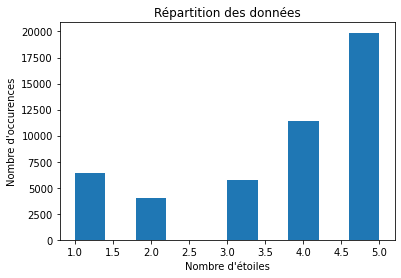

In [9]:
data = pd.read_csv("./yelp-text-by-stars.csv", sep=";", encoding = "ISO-8859-1")
data_array = data.values
X = data_array[:,1]
Y = data_array[:,0]

Y = Y.astype(np.int)
print("Taille de l'échantillon : ", X.shape)
plt.title("Répartition des données")
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre d'occurences")
plt.hist(Y)
plt.show()

Le fichier contient 47 371 avis textuels accompagnés d'une note de 1 à 5. On entraine notre Pipeline sur ce jeu de données.

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

cv = cross_validate(pipeline, X, Y, cv=kf, scoring={"Accuracy" : make_scorer(accuracy_score)})
cv_acc = cv['test_Accuracy']
print("Accuracy :", round(np.mean(cv_acc),2)*100,"+/-", round(np.std(cv_acc)*100,1),"%")

Accuracy : 54.0 +/- 0.3 %


La classification doit être faite sur 5 catégories différentes, ce qui la rend plus difficile. Cependant, notre pipeline permet d'obtenir une précision correcte (57 %) en un minimum de lignes de code (mais avec un temps de calcul très grand).

Pour améliorer les performances, on peut également se ramener à une classification binaire. 
On associe la classe 1 aux lieux disposant de 4 ou 5 étoiles.

In [11]:
Y[Y<4] = 0
Y[Y>3]= 1

cv = cross_validate(pipeline, X, Y, cv=kf, scoring={"Accuracy" : make_scorer(accuracy_score)})
cv_acc = cv['test_Accuracy']
print("Accuracy :", round(np.mean(cv_acc),2)*100,"+/-", round(np.std(cv_acc)*100,1),"%")

Accuracy : 80.0 +/- 0.3 %


Effectivement, cela permet d'augmenter l'accuracy d'environ 46%, ce qui n'est pas négligeable, mais nous perdons cependant de l'information dans le procédé.

# Conclusion

Ce TP dresse un tableau assez large des différentes méthodes et techniques pouvant intervenir dans une procédure de
*Machine Learning*. On notera finalement l'importance d'un bon traitement des données en amont de l'algorithme 
d'apprentissage à proprement parlé pour améliorer les performances et le temps de calculs (PCA, Normalisation, 
Encodage OneHot, Imputer). 

Les algorithmes sont également sensibles aux hyperparamètres qu'il faut choisir correctement, c'est pourquoi des 
procédures de tests de ces paramètres peuvent être nécessaires. Enfin, travailler avec des données textuelles augmente
la difficulté de l'apprentissage : il faut savoir trouver la transformation adéquate pour que ces données soient exploitables par les algorithmes classiques.